In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
import optuna

# 데이터 로드
train = pd.read_csv("../data/train.csv").drop(columns=['ID'])
test = pd.read_csv("../data/test.csv").drop(columns=['ID'])

X = train.drop('임신 성공 여부', axis=1)
y = train['임신 성공 여부']

categorical_columns = [
    "시술 시기 코드", "시술 당시 나이", "시술 유형", "특정 시술 유형", "배란 자극 여부", "배란 유도 유형",
    "단일 배아 이식 여부", "착상 전 유전 검사 사용 여부", "착상 전 유전 진단 사용 여부", "남성 주 불임 원인",
    "남성 부 불임 원인", "여성 주 불임 원인", "여성 부 불임 원인", "부부 주 불임 원인", "부부 부 불임 원인",
    "불명확 불임 원인", "불임 원인 - 난관 질환", "불임 원인 - 남성 요인", "불임 원인 - 배란 장애",
    "불임 원인 - 여성 요인", "불임 원인 - 자궁경부 문제", "불임 원인 - 자궁내막증", "불임 원인 - 정자 농도",
    "불임 원인 - 정자 면역학적 요인", "불임 원인 - 정자 운동성", "불임 원인 - 정자 형태", "배아 생성 주요 이유",
    "총 시술 횟수", "클리닉 내 총 시술 횟수", "IVF 시술 횟수", "DI 시술 횟수", "총 임신 횟수", "IVF 임신 횟수",
    "DI 임신 횟수", "총 출산 횟수", "IVF 출산 횟수", "DI 출산 횟수", "난자 출처", "정자 출처",
    "난자 기증자 나이", "정자 기증자 나이", "동결 배아 사용 여부", "신선 배아 사용 여부", "기증 배아 사용 여부",
    "대리모 여부", "PGD 시술 여부", "PGS 시술 여부"
]

# 카테고리형 컬럼을 문자열로 변환
for col in categorical_columns:
    X[col] = X[col].astype(str)
    test[col] = test[col].astype(str)

ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

X_train_encoded = X.copy()
X_train_encoded[categorical_columns] = ordinal_encoder.fit_transform(X[categorical_columns])

X_test_encoded = test.copy()
X_test_encoded[categorical_columns] = ordinal_encoder.transform(test[categorical_columns])

numeric_columns = [
    "임신 시도 또는 마지막 임신 경과 연수", "총 생성 배아 수", "미세주입된 난자 수", "미세주입에서 생성된 배아 수",
    "이식된 배아 수", "미세주입 배아 이식 수", "저장된 배아 수", "미세주입 후 저장된 배아 수", "해동된 배아 수",
    "해동 난자 수", "수집된 신선 난자 수", "저장된 신선 난자 수", "혼합된 난자 수", "파트너 정자와 혼합된 난자 수",
    "기증자 정자와 혼합된 난자 수", "난자 채취 경과일", "난자 해동 경과일", "난자 혼합 경과일", "배아 이식 경과일",
    "배아 해동 경과일"
]

X_train_encoded[numeric_columns] = X_train_encoded[numeric_columns].fillna(0)
X_test_encoded[numeric_columns] = X_test_encoded[numeric_columns].fillna(0)

# 🎯 1:1 비율로 Test 데이터 분할 (20% 중 절반이 1, 절반이 0)
test_size = int(len(y) * 0.2 / 2)

y_0 = y[y == 0]
y_1 = y[y == 1]

# 1과 0에서 동일한 개수 추출 (각각 test_size만큼)
y_test_0 = y_0.sample(n=test_size, random_state=42)
y_test_1 = y_1.sample(n=test_size, random_state=42)

# 나머지 데이터는 train으로 사용
y_train_0 = y_0.drop(y_test_0.index)
y_train_1 = y_1.drop(y_test_1.index)

# X도 동일하게 맞춰줌
X_test = pd.concat([X.loc[y_test_0.index], X.loc[y_test_1.index]])
y_test = pd.concat([y_test_0, y_test_1])

X_train = pd.concat([X.loc[y_train_0.index], X.loc[y_train_1.index]])
y_train = pd.concat([y_train_0, y_train_1])

# 🎯 언더샘플링 적용 (0과 1을 동일 개수로 맞춤)
rus = RandomUnderSampler(sampling_strategy=1.0, random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

In [8]:
import optuna
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Optuna 최적화 함수
def objective(trial):
    lr_C = trial.suggest_float("lr_C", 0.01, 10.0)
    dt_max_depth = trial.suggest_int("dt_max_depth", 2, 20)
    knn_neighbors = trial.suggest_int("knn_neighbors", 3, 15)
    rf_n_estimators = trial.suggest_int("rf_n_estimators", 50, 300)
    voting_type = trial.suggest_categorical("voting", ["hard", "soft"])

    models = [
        ('lr', LogisticRegression(C=lr_C, random_state=42)),
        ('dt', DecisionTreeClassifier(max_depth=dt_max_depth, random_state=42)),
        ('lda', LinearDiscriminantAnalysis()),
        ('rf', RandomForestClassifier(n_estimators=rf_n_estimators, random_state=42)),
        ('knn', KNeighborsClassifier(n_neighbors=knn_neighbors))
    ]

    model = VotingClassifier(estimators=models, voting=voting_type)
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)

# Optuna 실행
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)  # 더 많은 탐색을 수행

# 최적 하이퍼파라미터 가져오기
best_params = study.best_params

# 최적 하이퍼파라미터로 모델 생성
models = [
    ('lr', LogisticRegression(C=best_params['lr_C'], random_state=42)),
    ('dt', DecisionTreeClassifier(max_depth=best_params['dt_max_depth'], random_state=42)),
    ('lda', LinearDiscriminantAnalysis()),
    ('rf', RandomForestClassifier(n_estimators=best_params['rf_n_estimators'], random_state=42)),
    ('knn', KNeighborsClassifier(n_neighbors=best_params['knn_neighbors']))
]

final_voting_type = best_params["voting"]
final_model = VotingClassifier(estimators=models, voting=final_voting_type)
final_model.fit(X_train_resampled, y_train_resampled)

# 최종 예측 수행
y_pred_final = final_model.predict(test)


[I 2025-02-18 01:06:37,136] A new study created in memory with name: no-name-e6395030-bec8-460b-8f8d-605d8e3258ba
[W 2025-02-18 01:06:37,332] Trial 0 failed with parameters: {'lr_C': 3.5173800853493775, 'dt_max_depth': 17, 'knn_neighbors': 4, 'rf_n_estimators': 242, 'voting': 'soft'} because of the following error: ValueError("could not convert string to float: 'TRJXFG'").
Traceback (most recent call last):
  File "C:\Users\pung\anaconda3\Lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\pung\AppData\Local\Temp\ipykernel_17868\301164215.py", line 27, in objective
    model.fit(X_train_resampled, y_train_resampled)
  File "C:\Users\pung\anaconda3\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\pung\anaconda3\Lib\site-packages\sklearn\utils\validation.py", lin

ValueError: could not convert string to float: 'TRJXFG'

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Fail", "Success"], yticklabels=["Fail", "Success"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()

# 평가
y_pred_hard = VotingClassifier(estimators=models, voting="hard").fit(X_train_resampled, y_train_resampled).predict(X_test)
y_pred_soft = VotingClassifier(estimators=models, voting="soft").fit(X_train_resampled, y_train_resampled).predict(X_test)

plot_confusion_matrix(y_test, y_pred_hard, "Hard Voting Confusion Matrix")
plot_confusion_matrix(y_test, y_pred_soft, "Soft Voting Confusion Matrix")


In [9]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import  OrdinalEncoder
from sklearn.ensemble import ExtraTreesClassifier

train = pd.read_csv("../data/train.csv").drop(columns=['ID'])
test = pd.read_csv("../data/test.csv").drop(columns=['ID'])

X = train.drop('임신 성공 여부', axis=1)
y = train['임신 성공 여부']

categorical_columns = [
    "시술 시기 코드",
    "시술 당시 나이",
    "시술 유형",
    "특정 시술 유형",
    "배란 자극 여부",
    "배란 유도 유형",
    "단일 배아 이식 여부",
    "착상 전 유전 검사 사용 여부",
    "착상 전 유전 진단 사용 여부",
    "남성 주 불임 원인",
    "남성 부 불임 원인",
    "여성 주 불임 원인",
    "여성 부 불임 원인",
    "부부 주 불임 원인",
    "부부 부 불임 원인",
    "불명확 불임 원인",
    "불임 원인 - 난관 질환",
    "불임 원인 - 남성 요인",
    "불임 원인 - 배란 장애",
    "불임 원인 - 여성 요인",
    "불임 원인 - 자궁경부 문제",
    "불임 원인 - 자궁내막증",
    "불임 원인 - 정자 농도",
    "불임 원인 - 정자 면역학적 요인",
    "불임 원인 - 정자 운동성",
    "불임 원인 - 정자 형태",
    "배아 생성 주요 이유",
    "총 시술 횟수",
    "클리닉 내 총 시술 횟수",
    "IVF 시술 횟수",
    "DI 시술 횟수",
    "총 임신 횟수",
    "IVF 임신 횟수",
    "DI 임신 횟수",
    "총 출산 횟수",
    "IVF 출산 횟수",
    "DI 출산 횟수",
    "난자 출처",
    "정자 출처",
    "난자 기증자 나이",
    "정자 기증자 나이",
    "동결 배아 사용 여부",
    "신선 배아 사용 여부",
    "기증 배아 사용 여부",
    "대리모 여부",
    "PGD 시술 여부",
    "PGS 시술 여부"
]

# 카테고리형 컬럼들을 문자열로 변환
for col in categorical_columns:
    X[col] = X[col].astype(str)
    test[col] = test[col].astype(str)

ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

X_train_encoded = X.copy()
X_train_encoded[categorical_columns] = ordinal_encoder.fit_transform(X[categorical_columns])

X_test_encoded = test.copy()
X_test_encoded[categorical_columns] = ordinal_encoder.transform(test[categorical_columns])

numeric_columns = [
    "임신 시도 또는 마지막 임신 경과 연수",
    "총 생성 배아 수",
    "미세주입된 난자 수",
    "미세주입에서 생성된 배아 수",
    "이식된 배아 수",
    "미세주입 배아 이식 수",
    "저장된 배아 수",
    "미세주입 후 저장된 배아 수",
    "해동된 배아 수",
    "해동 난자 수",
    "수집된 신선 난자 수",
    "저장된 신선 난자 수",
    "혼합된 난자 수",
    "파트너 정자와 혼합된 난자 수",
    "기증자 정자와 혼합된 난자 수",
    "난자 채취 경과일",
    "난자 해동 경과일",
    "난자 혼합 경과일",
    "배아 이식 경과일",
    "배아 해동 경과일"
]

X_train_encoded[numeric_columns] = X_train_encoded[numeric_columns].fillna(0)
X_test_encoded[numeric_columns] = X_test_encoded[numeric_columns].fillna(0)

Accuracy: 0.5508
F1 Score: 0.2761


C:\Users\pung\anaconda3\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
C:\Users\pung\anaconda3\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 54056 (\N{HANGUL SYLLABLE PAE}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
C:\Users\pung\anaconda3\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
C:\Users\pung\anaconda3\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 44277 (\N{HANGUL SYLLABLE GONG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
C:\Users\pung\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\pung\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) 

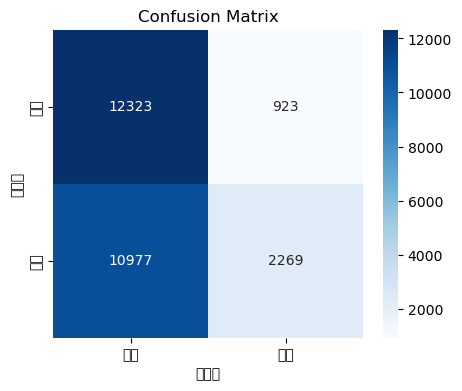

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# 데이터 분할 (8:2)
X_train, X_val, y_train, y_val = train_test_split(X_train_encoded, y, test_size=0.2, stratify=y, random_state=42)

# 언더샘플링 함수
def undersample(X, y):
    df = pd.concat([X, y], axis=1)
    class_counts = df['임신 성공 여부'].value_counts()
    min_count = class_counts.min()
    
    df_balanced = pd.concat([
        resample(df[df['임신 성공 여부'] == 0], replace=False, n_samples=min_count, random_state=42),
        resample(df[df['임신 성공 여부'] == 1], replace=False, n_samples=min_count, random_state=42)
    ])
    
    return df_balanced.drop(columns=['임신 성공 여부']), df_balanced['임신 성공 여부']

# 검증 데이터 언더샘플링
X_val_balanced, y_val_balanced = undersample(X_val, y_val)

# 개별 모델 정의
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
et_clf = ExtraTreesClassifier(n_estimators=100, random_state=42)
gb_clf = GradientBoostingClassifier(n_estimators=100, random_state=42)

# 앙상블 (Voting Classifier)
ensemble_clf = VotingClassifier(
    estimators=[
        ('rf', rf_clf),
        ('et', et_clf),
        ('gb', gb_clf)
    ],
    voting='soft'
)

# 모델 학습
ensemble_clf.fit(X_train, y_train)

# 검증 데이터 예측
y_pred = ensemble_clf.predict(X_val_balanced)

# 성능 평가
accuracy = accuracy_score(y_val_balanced, y_pred)
f1 = f1_score(y_val_balanced, y_pred)
cm = confusion_matrix(y_val_balanced, y_pred)

print(f'Accuracy: {accuracy:.4f}')
print(f'F1 Score: {f1:.4f}')

# 컨퓨전 매트릭스 시각화
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['실패', '성공'], yticklabels=['실패', '성공'])
plt.xlabel('예측값')
plt.ylabel('실제값')
plt.title('Confusion Matrix')
plt.show()


In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, VotingClassifier
from sklearn.metrics import confusion_matrix, classification_report
import xgboost as xgb
import lightgbm as lgb

# 전처리된 훈련 데이터와 테스트 데이터를 파일에서 로드
X_train_encoded = pd.read_csv('../data/train_encoded.csv')
X_test_encoded = pd.read_csv('../data/test_encoded.csv')

# 타겟 변수와 특성 분리
y = X_train_encoded['임신 성공 여부']
X = X_train_encoded.drop('임신 성공 여부', axis=1)

# 훈련 데이터 나누기
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델 정의 (여러 모델을 사용)
et_model = ExtraTreesClassifier(random_state=42)
rf_model = RandomForestClassifier(random_state=42)
xgb_model = xgb.XGBClassifier(random_state=42)
lgb_model = lgb.LGBMClassifier(random_state=42)

# 앙상블 모델 정의 (Voting Classifier)
voting_model = VotingClassifier(estimators=[
    ('et', et_model),
    ('rf', rf_model),
    ('xgb', xgb_model),
    ('lgb', lgb_model)
], voting='soft')  # soft voting: 예측 확률의 평균으로 최종 예측

# 모델 학습
voting_model.fit(X_train, y_train)

# 예측
y_pred = voting_model.predict(X_val)
y_pred_proba = voting_model.predict_proba(X_val)[:, 1]  # 예측 확률

# 성능 평가
print("Confusion Matrix")
print(confusion_matrix(y_val, y_pred))
print("\nClassification Report")
print(classification_report(y_val, y_pred))

# 예측 결과를 sample_submission 파일에 저장
pred_proba = voting_model.predict_proba(X_test_encoded)[:, 1]
sample_submission = pd.read_csv('../submission/sample_submission.csv')
sample_submission['probability'] = pred_proba

# 제출 파일로 저장
sample_submission.to_csv('../submission/baseline_submit.csv', index=False)

print("예측 결과가 'baseline_submit.csv'에 저장되었습니다.")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 53102, number of negative: 151978
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039907 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 716
[LightGBM] [Info] Number of data points in the train set: 205080, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.258933 -> initscore=-1.051521
[LightGBM] [Info] Start training from score -1.051521
Confusion Matrix
[[35899  2246]
 [11039  2087]]

Classification Report
              precision    recall  f1-score   support

           0       0.76      0.94      0.84     38145
           1       0.48      0.16      0.24     13126

    accuracy                           0.74     51271
   macro avg       0.62      0.55      0.54     51271
weighted avg      

In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, VotingClassifier
from sklearn.metrics import confusion_matrix, classification_report
import xgboost as xgb
import lightgbm as lgb

# 전처리된 훈련 데이터와 테스트 데이터를 파일에서 로드
X_train_encoded = pd.read_csv('../data/train_encoded.csv')
X_test_encoded = pd.read_csv('../data/test_encoded.csv')

# 타겟 변수와 특성 분리
y = X_train_encoded['임신 성공 여부']
X = X_train_encoded.drop('임신 성공 여부', axis=1)

# 훈련 데이터 나누기
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 언더샘플링 함수
def undersample(X, y):
    df = pd.concat([X, y], axis=1)
    class_counts = df['임신 성공 여부'].value_counts()
    min_count = class_counts.min()
    
    df_balanced = pd.concat([
        resample(df[df['임신 성공 여부'] == 0], replace=False, n_samples=min_count, random_state=42),
        resample(df[df['임신 성공 여부'] == 1], replace=False, n_samples=min_count, random_state=42)
    ])
    
    return df_balanced.drop(columns=['임신 성공 여부']), df_balanced['임신 성공 여부']

# 검증 데이터 언더샘플링
X_val, y_val = undersample(X_val, y_val)

# 모델 정의 (여러 모델을 사용)
et_model = ExtraTreesClassifier(random_state=42)
rf_model = RandomForestClassifier(random_state=42)
xgb_model = xgb.XGBClassifier(random_state=42)
lgb_model = lgb.LGBMClassifier(random_state=42)

# 앙상블 모델 정의 (Voting Classifier)
voting_model = VotingClassifier(estimators=[
    ('et', et_model),
    ('rf', rf_model),
    ('xgb', xgb_model),
    ('lgb', lgb_model)
], voting='soft')  # soft voting: 예측 확률의 평균으로 최종 예측

# 모델 학습
voting_model.fit(X_train, y_train)

# 예측
y_pred = voting_model.predict(X_val)
y_pred_proba = voting_model.predict_proba(X_val)[:, 1]  # 예측 확률

# 성능 평가
print("Confusion Matrix")
print(confusion_matrix(y_val, y_pred))
print("\nClassification Report")
print(classification_report(y_val, y_pred))

# 예측 결과를 sample_submission 파일에 저장
pred_proba = voting_model.predict_proba(X_test_encoded)[:, 1]
sample_submission = pd.read_csv('../submission/sample_submission.csv')
sample_submission['probability'] = pred_proba

# 제출 파일로 저장
sample_submission.to_csv('../submission/baseline_submit.csv', index=False)

print("예측 결과가 'baseline_submit.csv'에 저장되었습니다.")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 53102, number of negative: 151978
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027328 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 716
[LightGBM] [Info] Number of data points in the train set: 205080, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.258933 -> initscore=-1.051521
[LightGBM] [Info] Start training from score -1.051521
Confusion Matrix
[[12359   767]
 [11039  2087]]

Classification Report
              precision    recall  f1-score   support

           0       0.53      0.94      0.68     13126
           1       0.73      0.16      0.26     13126

    accuracy                           0.55     26252
   macro avg       0.63      0.55      0.47     26252
weighted avg      